<a href="https://colab.research.google.com/github/nahbos/For-Two-Dinners----3DV/blob/main/3dv_ivenoidea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright @nahbos

2023-13-7

Harki Copy Kone Bere Jahanam ))


import libraries ..

In [1]:
# !pip install open3d

In [2]:
# !pip install icp

In [3]:
import open3d as o3d
from open3d import *
import numpy as np
import struct
from natsort import natsorted
import os
import time
from tqdm import tqdm
import copy
from matplotlib import pyplot as plt

# Data preparation

loading dataset ..

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!wget -nc https://raw.githubusercontent.com/nahbos/For-Two-Dinners----3DV/main/gt_pose_00.txt

--2023-07-13 13:21:44--  https://raw.githubusercontent.com/nahbos/For-Two-Dinners----3DV/main/gt_pose_00.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 728871 (712K) [text/plain]
Saving to: ‘gt_pose_00.txt’

gt_pose_00.txt      100%[===================>] 711.79K  --.-KB/s    in 0.04s   

2023-07-13 13:21:44 (16.9 MB/s) - ‘gt_pose_00.txt’ saved [728871/728871]



In [6]:
# From the file vis.py

def convert_kitti_bin_to_pcd(binFilePath):
    # Load binary point cloud
    bin_pcd = np.fromfile(binFilePath, dtype=np.float32)

    # Reshape and drop reflection values
    points = bin_pcd.reshape((-1, 4))[:, 0:3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    # Convert to Open3D point cloud
    return pcd

input_dir = "/content/drive/MyDrive/00/"
input_files = natsorted(os.listdir(input_dir))

In [7]:
pcd_list = []

for ele in tqdm(input_files):
  pcd = convert_kitti_bin_to_pcd(os.path.join(input_dir, input_files[0]))
  pcd_list.append(np.asanyarray(pcd.points))

pcd_list = np.array(pcd_list)

100%|██████████| 142/142 [00:34<00:00,  4.17it/s]


In [8]:
pcd_list.shape

(142, 124668, 3)

# Using a github file called icp.py


In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

# ICP

In [10]:
def icpoint(pcd_list, threshold=0.00001):

  map_ = []
  transformations =[]

  # getting open3d to display the video
  vis = o3d.visualization.Visualizer()
  vis.create_window()

  for idx, ele in enumerate(tqdm(pcd_list)):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ele)
    pcd = pcd.voxel_down_sample(voxel_size=0.1)
    pcd_copy = copy.deepcopy(pcd)

    if idx == 0:
        transformations.append(np.eye(4))
        map_ = np.array(pcd.points)
        map_ = np.round(np.array(pcd.points),decimals=1)
        map_ = np.unique(map_, axis=0)
        continue

    pcd_n1 = o3d.geometry.PointCloud()
    pcd_n1.points = o3d.utility.Vector3dVector(pcd_list[idx-1])
    pcd_n1 = pcd_n1.voxel_down_sample(voxel_size=0.1)
    pcd_n1_cp = copy.deepcopy(pcd_n1)

    pcd_p = np.asarray(pcd.points)
    pcd_n1_p = np.asarray(pcd_n1.points)

    _min_count = min(pcd_p.shape[0], pcd_n1_p.shape[0])

    pcd_p = pcd_p[:_min_count]
    pcd_n1_p = pcd_n1_p[:_min_count]

    if idx == 1:
        T, _, _ = icp(pcd_p, pcd_n1_p)
        transformations.append(T)
        continue

    T, _, _ = icp(pcd_p, pcd_n1_p)
    transformations.append(T)

    for _ in range(len(transformations)-1, -1, -1):
        pcd_copy.transform(transformations[_])

    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)

    map_ = np.concatenate([map_, np.array(pcd_copy.points)])
    map_ = np.round(map_,decimals=1)
    map_ = np.unique(map_,axis=0)

    map_pcd = o3d.geometry.PointCloud()
    map_pcd.points = o3d.utility.Vector3dVector(map_)
    vis.add_geometry(map_pcd)
    vis.poll_events()
    vis.update_renderer()
    # vis.capture_screen_image("./result.png")

  return map_, transformations

In [11]:
res = icpoint(pcd_list)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  2%|▏         | 3/142 [00:00<00:51,  2.70it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  3%|▎         | 4/142 [00:01<01:00,  2.29it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  4%|▎         | 5/142 [00:02<01:02,  2.17it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  4%|▍         | 6/142 [00:02<01:06,  2.06it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  5%|▍         | 7/142 [00:03<01:05,  2.05it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  6%|▌         | 8/142 [00:03<01:05,  2.04it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  6%|▋         | 9/142 [00:04<01:04,  2.06it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  7%|▋         | 10/142 [00:04<01:03,  2.07it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  8%|▊         | 11/142 [00:04<01:03,  2.06it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  8%|▊         | 12/142 [00:05<01:04,  2.03it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  9%|▉         | 13/142 [00:05<01:02,  2.05it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 10%|▉         | 14/142 [00:06<01:03,  2.01it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 11%|█         | 15/142 [00:07<01:09,  1.83it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 11%|█▏        | 16/142 [00:07<01:17,  1.62it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 12%|█▏        | 17/142 [00:08<01:23,  1.50it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 13%|█▎        | 18/142 [00:09<01:26,  1.44it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 13%|█▎        | 19/142 [00:10<01:27,  1.40it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 14%|█▍        | 20/142 [00:11<01:29,  1.37it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 15%|█▍        | 21/142 [00:11<01:28,  1.36it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 16%|█▌        | 23/142 [00:13<01:22,  1.45it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 17%|█▋        | 24/142 [00:13<01:14,  1.57it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 18%|█▊        | 26/142 [00:14<01:05,  1.76it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 19%|█▉        | 27/142 [00:15<01:03,  1.81it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 20%|█▉        | 28/142 [00:15<01:01,  1.86it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 20%|██        | 29/142 [00:16<00:59,  1.89it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 21%|██        | 30/142 [00:16<00:58,  1.93it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 22%|██▏       | 31/142 [00:17<00:56,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 23%|██▎       | 32/142 [00:17<00:55,  1.98it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 23%|██▎       | 33/142 [00:18<00:54,  2.00it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 24%|██▍       | 34/142 [00:18<00:53,  2.01it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 25%|██▍       | 35/142 [00:19<00:53,  2.02it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 25%|██▌       | 36/142 [00:19<00:52,  2.03it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 27%|██▋       | 38/142 [00:20<00:51,  2.04it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 27%|██▋       | 39/142 [00:21<00:50,  2.02it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 28%|██▊       | 40/142 [00:21<00:50,  2.03it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 29%|██▉       | 41/142 [00:22<00:49,  2.03it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 30%|██▉       | 42/142 [00:22<00:49,  2.02it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 30%|███       | 43/142 [00:23<00:54,  1.81it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 31%|███       | 44/142 [00:23<00:59,  1.65it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 32%|███▏      | 45/142 [00:24<01:03,  1.53it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 32%|███▏      | 46/142 [00:25<01:06,  1.45it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 33%|███▎      | 47/142 [00:26<01:08,  1.39it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 34%|███▍      | 48/142 [00:27<01:09,  1.35it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 35%|███▍      | 49/142 [00:27<01:10,  1.32it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 36%|███▌      | 51/142 [00:29<01:01,  1.48it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 37%|███▋      | 52/142 [00:29<00:56,  1.61it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 37%|███▋      | 53/142 [00:30<00:51,  1.71it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 38%|███▊      | 54/142 [00:30<00:49,  1.79it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 39%|███▊      | 55/142 [00:31<00:47,  1.85it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 40%|████      | 57/142 [00:32<00:44,  1.91it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 41%|████      | 58/142 [00:32<00:43,  1.93it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 42%|████▏     | 59/142 [00:33<00:42,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 43%|████▎     | 61/142 [00:34<00:41,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 44%|████▍     | 63/142 [00:35<00:40,  1.97it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 46%|████▌     | 65/142 [00:36<00:39,  1.97it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 47%|████▋     | 67/142 [00:37<00:37,  1.99it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 49%|████▊     | 69/142 [00:38<00:36,  1.99it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 49%|████▉     | 70/142 [00:38<00:37,  1.94it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 50%|█████     | 71/142 [00:39<00:42,  1.66it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 51%|█████     | 72/142 [00:40<00:46,  1.52it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 51%|█████▏    | 73/142 [00:41<00:48,  1.43it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 52%|█████▏    | 74/142 [00:41<00:48,  1.39it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 53%|█████▎    | 75/142 [00:42<00:49,  1.35it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 54%|█████▎    | 76/142 [00:43<00:49,  1.34it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 55%|█████▍    | 78/142 [00:44<00:46,  1.37it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 56%|█████▌    | 79/142 [00:45<00:41,  1.51it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 56%|█████▋    | 80/142 [00:45<00:38,  1.63it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 57%|█████▋    | 81/142 [00:46<00:35,  1.72it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 58%|█████▊    | 82/142 [00:46<00:33,  1.79it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 58%|█████▊    | 83/142 [00:47<00:32,  1.84it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 59%|█████▉    | 84/142 [00:47<00:30,  1.88it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 60%|█████▉    | 85/142 [00:48<00:29,  1.91it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 61%|██████    | 86/142 [00:48<00:28,  1.94it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 61%|██████▏   | 87/142 [00:49<00:28,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 62%|██████▏   | 88/142 [00:49<00:27,  1.99it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 63%|██████▎   | 89/142 [00:50<00:26,  1.99it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 63%|██████▎   | 90/142 [00:50<00:26,  1.98it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 64%|██████▍   | 91/142 [00:51<00:25,  1.98it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 65%|██████▍   | 92/142 [00:51<00:24,  2.00it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 65%|██████▌   | 93/142 [00:52<00:24,  2.01it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 66%|██████▌   | 94/142 [00:52<00:23,  2.01it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 67%|██████▋   | 95/142 [00:53<00:23,  2.02it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 68%|██████▊   | 96/142 [00:53<00:22,  2.02it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 68%|██████▊   | 97/142 [00:54<00:22,  1.99it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 69%|██████▉   | 98/142 [00:55<00:24,  1.80it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 70%|██████▉   | 99/142 [00:55<00:26,  1.61it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 70%|███████   | 100/142 [00:56<00:28,  1.48it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 71%|███████   | 101/142 [00:57<00:29,  1.41it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 73%|███████▎  | 103/142 [00:58<00:28,  1.35it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 73%|███████▎  | 104/142 [00:59<00:28,  1.33it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 75%|███████▍  | 106/142 [01:00<00:23,  1.52it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 75%|███████▌  | 107/142 [01:01<00:21,  1.64it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 76%|███████▌  | 108/142 [01:01<00:19,  1.71it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 77%|███████▋  | 109/142 [01:02<00:18,  1.80it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 77%|███████▋  | 110/142 [01:02<00:17,  1.84it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 78%|███████▊  | 111/142 [01:03<00:16,  1.89it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 79%|███████▉  | 112/142 [01:03<00:15,  1.92it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 80%|███████▉  | 113/142 [01:04<00:14,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 80%|████████  | 114/142 [01:04<00:14,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 81%|████████  | 115/142 [01:05<00:13,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 82%|████████▏ | 116/142 [01:05<00:13,  1.96it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 82%|████████▏ | 117/142 [01:06<00:15,  1.63it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 83%|████████▎ | 118/142 [01:07<00:16,  1.44it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 85%|████████▍ | 120/142 [01:09<00:15,  1.47it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 85%|████████▌ | 121/142 [01:09<00:13,  1.55it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 86%|████████▌ | 122/142 [01:10<00:12,  1.66it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 87%|████████▋ | 123/142 [01:10<00:12,  1.54it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 87%|████████▋ | 124/142 [01:11<00:12,  1.43it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 88%|████████▊ | 125/142 [01:12<00:12,  1.38it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 89%|████████▊ | 126/142 [01:13<00:11,  1.36it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 89%|████████▉ | 127/142 [01:14<00:11,  1.32it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 90%|█████████ | 128/142 [01:14<00:10,  1.29it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 92%|█████████▏| 130/142 [01:16<00:08,  1.34it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 92%|█████████▏| 131/142 [01:16<00:07,  1.49it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 93%|█████████▎| 132/142 [01:17<00:06,  1.59it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 94%|█████████▎| 133/142 [01:17<00:05,  1.68it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 94%|█████████▍| 134/142 [01:18<00:04,  1.75it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 95%|█████████▌| 135/142 [01:18<00:03,  1.80it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 96%|█████████▌| 136/142 [01:19<00:03,  1.85it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 96%|█████████▋| 137/142 [01:19<00:02,  1.88it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 97%|█████████▋| 138/142 [01:20<00:02,  1.89it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 98%|█████████▊| 139/142 [01:20<00:01,  1.92it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 99%|█████████▊| 140/142 [01:21<00:01,  1.92it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


 99%|█████████▉| 141/142 [01:22<00:00,  1.93it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


100%|██████████| 142/142 [01:22<00:00,  1.72it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


In [37]:
def calculate_driving_lines(map_, transformation, name="icp"):

  # getting open3d to display the video
  vis = o3d.visualization.Visualizer()
  vis.create_window(visible=False)

  map_pcd = o3d.geometry.PointCloud()
  map_pcd.points = o3d.utility.Vector3dVector(map_)
  vis.add_geometry(map_pcd)
  vis.poll_events()
  vis.update_renderer()
  # vis.capture_screen_image("./results/result_{0}_map_drive_path.png".format(name))
  # vis.destroy_window()

  Centers = []
  Centers_gt = []
  gt_file = open("./gt_pose_00.txt").readlines()


  for pc_index in tqdm(range(len(transformation))):
      point_cloud = np.array([[0,0,100],[0,0,0]])
      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(point_cloud)
      pcd = pcd.voxel_down_sample(voxel_size=0.1)

      for _ in range(pc_index-1,-1,-1):
          pcd.transform(transformation[_])

      Centers.append(np.asarray(pcd.points)[0][:2])

      map_ = np.concatenate([map_, np.array(pcd.points)])

      point_cloud = np.array([[0,0,0]])
      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(point_cloud)
      pcd = pcd.voxel_down_sample(voxel_size=0.1)

      gt = gt_file[pc_index]
      gt = gt.strip()
      gt = np.array(list(map(np.float64, gt.split()))).reshape(3, 4)
      gt = np.concatenate([gt,np.array([[0,0,0,1]])])
      pcd.transform(gt)
      Centers_gt.append(np.asarray(pcd.points)[0][:2])


      vis = o3d.visualization.Visualizer()
      vis.create_window(visible=False)

      map_pcd = o3d.geometry.PointCloud()
      map_pcd.points = o3d.utility.Vector3dVector(map_)
      vis.add_geometry(map_pcd)
      vis.poll_events()
      vis.update_renderer()
      # vis.capture_screen_image("./results/result_{1}_world_map_{0}_drive_path.png".format(pc_index,name))
      # vis.destroy_window()

  Centers = np.array(Centers)
  Centers = Centers / (Centers.max(axis=0) + 0.00000000001)
  plt.plot(Centers[:,1],Centers[:,0],label="Estimated driving line")

  Centers_gt = np.array(Centers_gt) * (-1)
  Centers_gt = Centers_gt / (Centers_gt.max(axis=0) + 0.00000000001)
  plt.plot(Centers_gt[:,0],Centers_gt[:,1],label="Ground truth driving line")
  plt.title("Driving lines")
  plt.ylabel("Y axis (Normalized & Aligned)")
  plt.xlabel("X axis (Normalized & Aligned)")

  plt.legend()
  plt.show()

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


  7%|▋         | 10/142 [00:00<00:01, 96.74it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11

 22%|██▏       | 31/142 [00:00<00:00, 162.42it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11

 45%|████▌     | 64/142 [00:00<00:00, 236.65it/s]


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X1

 66%|██████▌   | 94/142 [00:00<00:00, 260.89it/s]

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11

100%|██████████| 142/142 [00:00<00:00, 241.42it/s]

[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initi

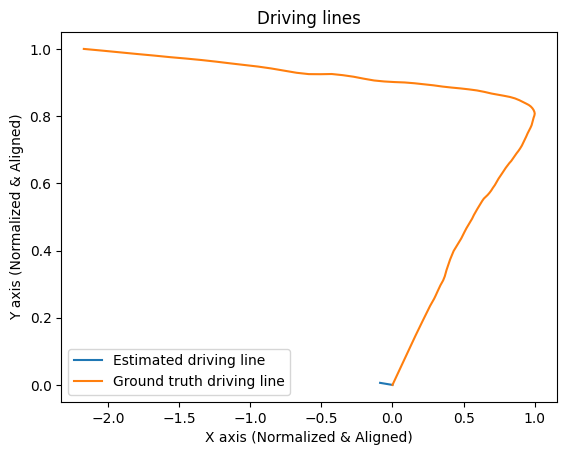

In [38]:
map_ = res[0]
transformation = res[1]
calculate_driving_lines(map_, transformation, name="icp")